In [14]:
import sklearn.metrics
from sklearn.utils.multiclass import unique_labels

from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Conv2D, Flatten, MaxPooling2D
from keras.models import Model
import keras.backend as K
import keras.layers as KL
import keras

import matplotlib.pyplot as plt
import numpy as np

In [37]:
import json

In [2]:
# Neural net setup
BINS_EDGE = np.load("./nn_data/s1p10_bins_edge.npy")
NUM_LABELS = 10
NUM_CLASSES = len(BINS_EDGE) - 1
NUM_SMOOTH = 3

In [3]:
def convolutional_block(X, num_filters, shape_filters, strides, stage):
    """
    Implementation of convolutional block in Residual network
    
    Input:
        X (tensor): input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        num_filters (list of 3 ints): list of number of filters
        shape_filters (list of 3 ints): list of filters' shape
        strides (list of 3 ints): list of strides
        stage (int): stage of this convolutional block in the whole ResNet
        
    Output:
        tensor of shape (m, n_H, n_W, n_C)
    """
    
    # retrieve filters shape from filters
    n1, n2, n3 = num_filters
    f1, f2, f3 = shape_filters
    
    # retrieve strides from strides
    s1, s2, s3 = strides
    
    # create name
    bn_name_base = 'bn_' + str(stage) + '_'
    conv_name_base = 'conv_' + str(stage) + '_'
    
    # save value of X
    X_shorcut = X
    
    # First component of the main path
    X = BatchNormalization(name=bn_name_base + 'a')(X)
    X = Activation('relu', name="feature_map_%d" % (stage - 1))(X)
    X = Conv2D(n1, (f1, f1), strides=[s1, s1], padding='same',
               name=conv_name_base + 'a')(X)
    
    # Second component of the main path
    X = BatchNormalization(name=bn_name_base + 'b')(X)
    X = Activation('relu')(X)
    X = Conv2D(n2, (f2, f2), strides=[s2, s2], padding='same',
               name=conv_name_base + 'b')(X)
    
    # Short-cut
    X_shorcut = Conv2D(n3, (f3, f3), strides=[s3, s3], padding='same', 
                       name=conv_name_base + 'c')(X_shorcut)
    
    X = KL.merge.add([X, X_shorcut])
    
    return X
def full_model(input_shape):
    """
    Define encoder architecture as ResNet8
    
    Input:
        input_shape (list of ints): shape of input image [n_H, n_W, n_C]
        
    Output:
        model: a Model instance
    """
    
    # Input
    X_input = Input(shape=input_shape)
    
    # Apply 1st convolution & max pooling on input
    X = Conv2D(32, (5, 5), strides=[2,2], padding='same', name='conv_0')(X_input)
    X = MaxPooling2D(pool_size=(3, 3), strides=[2,2])(X) 
    
    # First convolutional block
    X = convolutional_block(X, [32, 32, 32], [3, 3, 1], [2, 1, 2], stage=1)
    
    # Second convolutional block
    X = convolutional_block(X, [64, 64, 64], [3, 3, 1], [2, 1, 2], stage=2)
    
    # Third convolutional block
    X = convolutional_block(X, [128, 128, 128], [3, 3, 1], [2, 1, 2], stage=3)
    
    # Output layer of resnet-8
    X = Flatten()(X)
    X = Activation('relu')(X)
    
    # extract feature vector
    X_feature = Dropout(0.5)(X)
    
    # apply classifier body
    X_body = Dense(800, activation='relu')(X_feature)
    
    # apply classifier head
    y = []
    for i in range(NUM_LABELS):
        X_body_1 = Dropout(0.5)(X_body)
        out = Dense(NUM_CLASSES, activation='softmax', name="head_%d" % i)(X_body_1)
        y.append(out)
    
    model = Model(inputs=[X_input], outputs=y)    
    return model

In [4]:
model = full_model((200, 200, 1))
model.load_weights("./nn_data/model_checkpoint/weights-25-8.5545.hdf5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# Load validation data
X_val = np.load('./../s1p10_data/no_cut_CH2_validation_X.npy')
y_val_arr = np.load('./../s1p10_data/no_cut_CH2_validation_y.npy')
y_val = [y_val_arr[i, :, :]for i in range(NUM_LABELS)]

In [7]:
# Get model prediction
y_hat = model.predict(X_val, verbose=1)

2021/2021 [==============================] - 3s 1ms/step


In [9]:
# Check out 1st prediction
y_val_1 = np.argmax(y_val[0], axis=1)
y_hat_1 = np.argmax(y_hat[0], axis=1)

In [70]:
with open('./../s1p10_data/s1p10_classes_weight.json', 'r') as fp:
    CLASSES_WEIGHT = json.load(fp)

In [84]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    for i in range(cm.shape[0]):
        cm[i, :] = cm[i, :].astype('float') * CLASSES_WEIGHT[str(i)]
#     cm = cm[: 30, : 30]
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(50,50))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 0  0  0 ...  0  0  0]
 [ 0  0 11 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


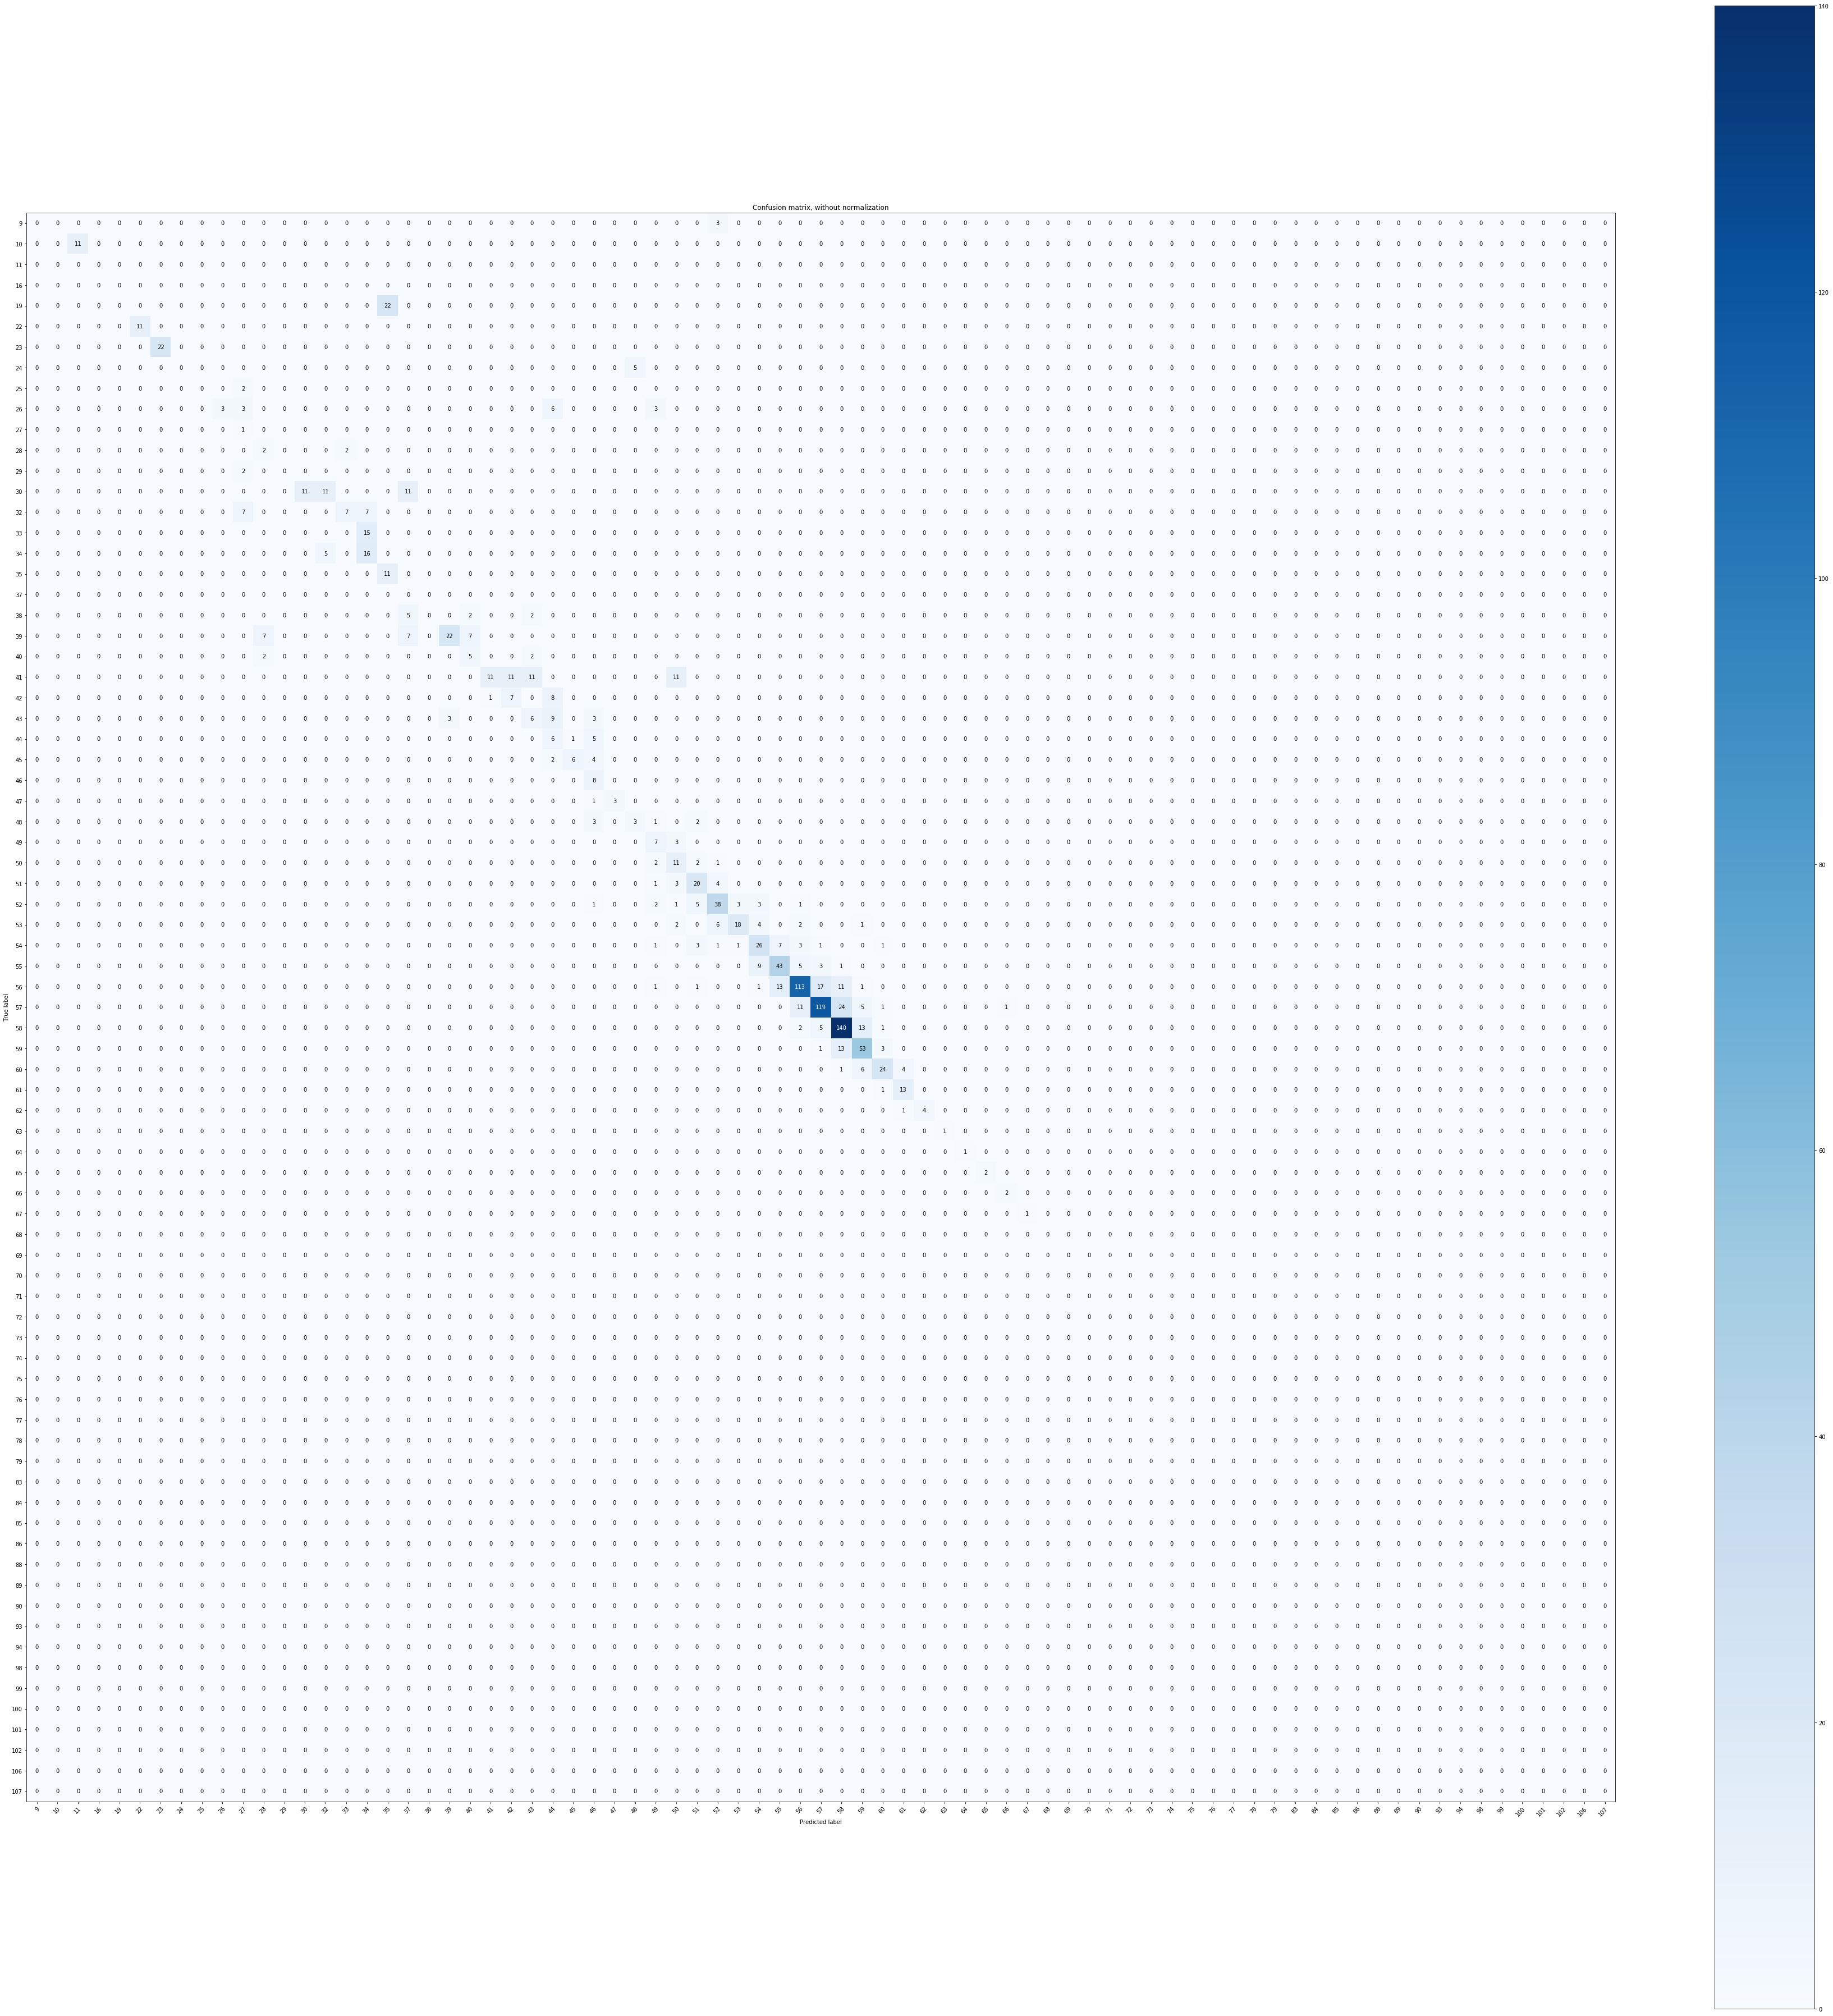

In [85]:
class_names = np.array([str(i) for i in range(114)])
# Log the confusion matrix as an image summary.
plot_confusion_matrix(y_val_1, y_hat_1, classes=class_names,
                      title='Confusion matrix, without normalization')
